# Cross Frequency function

In [59]:
import numpy as np
from scipy.signal import hilbert
from scipy.fftpack import fft, ifft

def Cros(X,
         dt,
         min_low_band,
         max_low_band,
         min_high_band,
         max_high_band):
    
    L = filt(X, dt, min_low_band, max_low_band)
    s = np.mean(L)
    phase = np.angle(hilbert(L-s))
    
    H = filt(X, dt, min_high_band, max_high_band)
    s = np.mean(H)
    amp = np.abs(hilbert(H-s))

    div = 10
    b = np.pi/div
    In = np.arange(0,2*np.pi,2*np.pi/div)
    P = np.zeros(div)
    for i in range(div):
        (I,) = np.where(np.abs(phase-(In[i]-np.pi))<b);
        P[i] = np.mean(amp[I])
    P = P/sum(P)
    return P

def filt(X, dt, a, b):
    """
    X is raw signal. dt is the time bin.
    """
    A = fft(X)
    char = np.zeros(len(X))
    char[int(a*dt):int(dt*b)] = 1.
    A = char*A
    A[0] = 0
    C = np.conj(A)
    C = C[::-1]
    C = np.append(np.array([0]),C[:-1])
    A = (A+C)/2.
    
    y = np.real(ifft(A))
    return y

def all_cros(X,
             dt,
             T,
             min_low_band,
             max_low_band,
             min_high_band,
             max_high_band):
    n = int(T/1000)
    dis = int(1/dt)
    P = np.zeros(10)
    for i in range(n):
        P = P + Cros(X[i*dis*1000:(i+1)*dis*1000], 1, min_low_band, max_low_band, min_high_band, max_high_band)
    P = P/sum(P)
    return P

def Entropy(f):
    return np.log(10) + sum(f*np.log(f))

def network(Ts, dt, noise, alpha, xx, XX, xX):
    e = .2
    i = .3

    E = .2
    I = .3
    ee = xx[0,0]
    ii = xx[1,1]
    ei = xx[0,1]
    ie = xx[1,0]
    
    EE = XX[0,0]
    II = XX[1,1]
    EI = XX[0,1]
    IE = XX[1,0]

    eE = xX[0,0]
    iI = xX[1,1]
    eI = xX[0,1]
    iE = xX[1,0]

    he = -np.log(1./(alpha*e) -1) - (ee*e - ei*i + eE*E - eI*I)
    hi = -np.log(1./(alpha*i) -1) - (ie*e - ii*i + iE*E - iI*I)
    HE = -np.log(1./(alpha*E) -1) - (EE*E - EI*I)
    HI = -np.log(1./(alpha*I) -1) - (IE*E - II*I)
    
    T = 1000*Ts+100.
    ddt = np.sqrt(dt)
    N = int(T/dt)
    x = np.zeros([2,N])
    y = np.zeros([2,N])
    x[0,0] = e + .01
    x[1,0] = i - .01

    y[0,0] = E - .01
    y[1,0] = I - .01

    for n in range(N-1):
        x[0,n+1] = x[0,n] + dt*(-alpha*x[0,n] + expit(ee*x[0,n] - ei*x[1,n] + eE*y[0,n] - eI*y[1,n] + he)) + ddt*noise*np.random.randn()
        x[1,n+1] = x[1,n] + dt*(-alpha*x[1,n] + expit(ie*x[0,n] - ii*x[1,n] + iE*y[0,n] - iI*y[1,n] + hi)) + ddt*noise*np.random.randn()
        y[0,n+1] = y[0,n] + dt*(-alpha*y[0,n] + expit(EE*y[0,n] - EI*y[1,n] + HE)) + ddt*noise*np.random.randn()
        y[1,n+1] = y[1,n] + dt*(-alpha*y[1,n] + expit(IE*y[0,n] - II*y[1,n] + HI)) + ddt*noise*np.random.randn()
    return x, y, he, hi

def cros_network(Ts, dt, noise, alpha, xx, XX, xX, min_low_band, max_low_band, min_high_band, max_high_band):
    x, y, he, hi = network(Ts, dt, noise, alpha, xx, XX, xX)
    return all_cros(sum(x+y), dt, Ts*1000, min_low_band, max_low_band, min_high_band, max_high_band)
    

In [ ]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
%matplotlib inline
X = np.cos(4*np.arange(0,50,.01))+((1-1.0*np.cos(4*np.arange(0,50,.01)))**2)*np.cos(18*np.arange(0,50,.01))
a = filt(X, 1, 3, 30)

a = Cros(X,1,20,50,100,200)

#plt.plot(X[0:1000])
plt.plot(a)
#plt.plot(np.abs(fft(X)[1:200]))


# Network of two oscilators

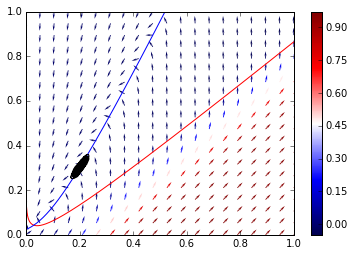

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy.special import expit
%matplotlib inline

xx = np.array([[24., 24.],[28., 11.]])
XX = np.array([[22., 17.],[14.5, 9.5]])
xX = np.array([[20., 0.],[0., 0.]])

e = .2
i = .3

E = .2
I = .3
alpha = .05
dt = .01
Ts = 10
T = 1000*Ts
noise = .0005
x, y, he, hi = network(Ts = Ts, dt = dt,  noise = noise, alpha = alpha, xx = xx, XX = XX, xX = xX)

Y, X = np.mgrid[0:1:20j, 0:1:20j]
U = -alpha*X + expit(xx[0,0]*X - xx[0,1]*Y +  he)
V = -alpha*Y + expit(xx[1,0]*X - xx[1,1]*Y +  hi)
speed = np.sqrt(U**2 + V**2)
UN = U/speed
VN = V/speed
plt.quiver(X, Y, UN, VN,        # data
           U,                   # colour the arrows based on this array
           cmap=cm.seismic,     # colour map
           headlength=7)        # length of the arrows

plt.colorbar()                  # adds the colour bar
mesh = np.arange(0.001,1,.001)
val1 = (np.log(1./(alpha*mesh) -1) + xx[0,0]*mesh + he)/xx[0,1]
val2 = (-np.log(1./(alpha*mesh) -1) + xx[1,1]*mesh - hi)/xx[1,0]
plt.plot(mesh, val1,'r')
plt.plot(val2, mesh,'b')
plt.plot(x[0,:], x[1,:],'k')
plt.axis([0, 1, 0, 1]);

# EIG without coupling

In [ ]:
alpha = .05

ee = xx[0,0]
ii = xx[1,1]
ei = xx[0,1]
ie = xx[1,0]

EE = XX[0,0]
II = XX[1,1]
EI = XX[0,1]
IE = XX[1,0]

eE = xX[0,0]
iI = xX[1,1]
eI = xX[0,1]
iE = xX[1,0]

xx = np.array([[22., 24.],[28., 11.]])
XX = np.array([[22., 16.],[14.9, 11.]])
xX = np.array([[3., 0.],[0., 0.]])

ee = 24.
ii = 11.
ei = 24.
ie = 28.

EE = 22.
II = 9.5
EI = 17.
IE = 14

eE = 10.
iI = 0
eI = 0
iE = 0

e = .2
i = .3

E = .2
I = .3

Df = np.array([[-alpha+alpha*ee*e*(1-alpha*e), -alpha*ei*e*(1-alpha*e)],[alpha*ie*i*(1-alpha*i),-alpha-(alpha*ii*i*(1-alpha*i))]])
DF = np.array([[-alpha+alpha*EE*E*(1-alpha*E), -alpha*EI*E*(1-alpha*E)],[alpha*IE*I*(1-alpha*I),-alpha-alpha*II*I*(1-alpha*I)]])
print Df
print DF
print np.linalg.eig(Df)
print np.linalg.eig(DF)
print np.trace(np.linalg.inv(Df+np.transpose(Df)))

# fast oscilator

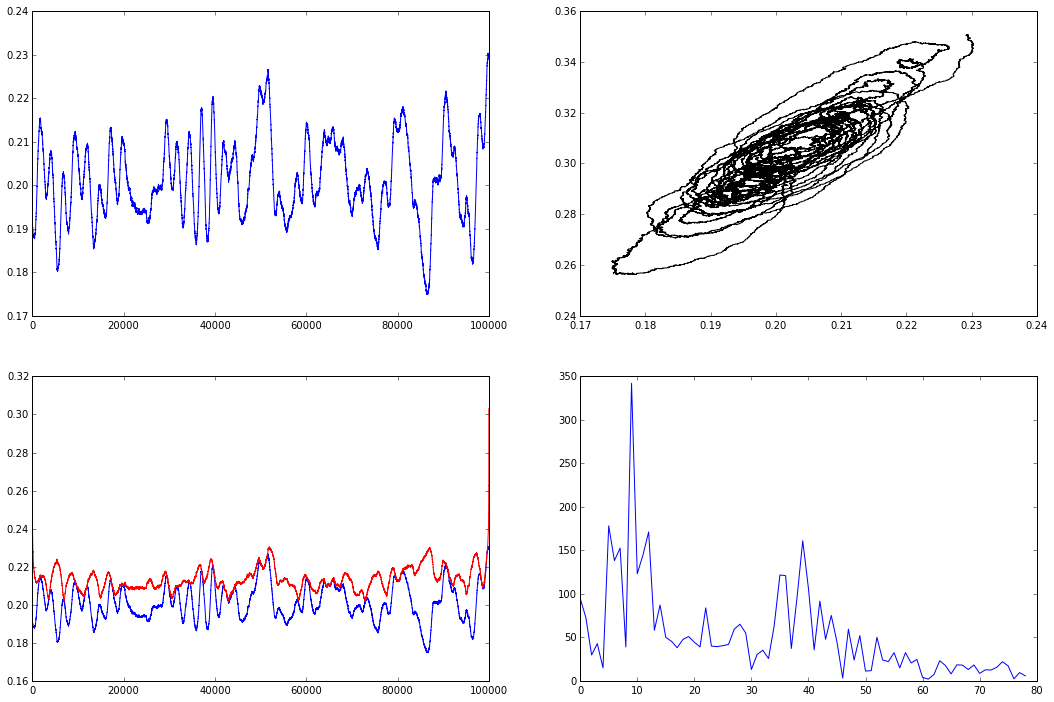

In [37]:
rec = x[0,-int((1000)/dt):]
a = np.mean(rec)
amp = np.abs(hilbert(rec-a))
f, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2)
f.set_size_inches(18,12)
ax1.plot(rec)
ax3.plot(rec)
ax3.plot(amp+a,'r')
ax2.plot(x[0,-int((1000)/dt):], x[1,-int((1000)/dt):],'k')
ax4.plot(np.abs(fft(rec)[1:80]))


# Slow oscilator

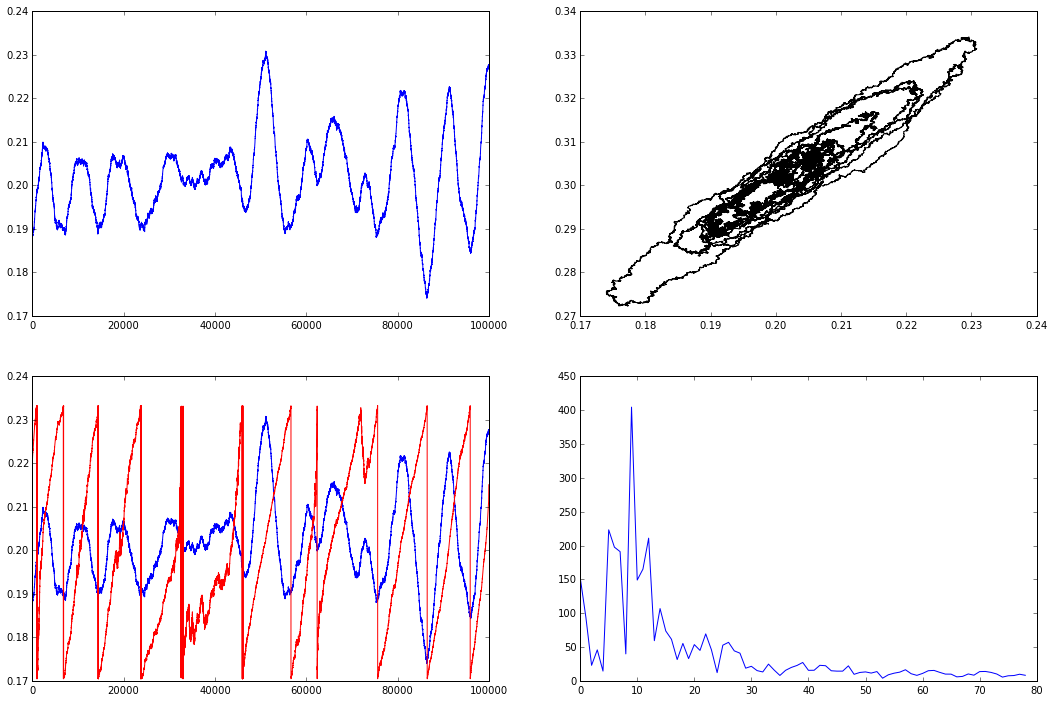

In [38]:
rec = y[0,-int((1000)/dt):]
a = np.mean(rec)
ang = .01*np.angle(hilbert(rec-a))
f, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2,2)
f.set_size_inches(18,12)
ax1.plot(rec)
ax3.plot(rec)
ax3.plot(ang+a,'r')
ax2.plot(y[0,-int((1000)/dt):], y[1,-int((1000)/dt):],'k')
ax4.plot(np.abs(fft(rec)[1:80]))

# overall

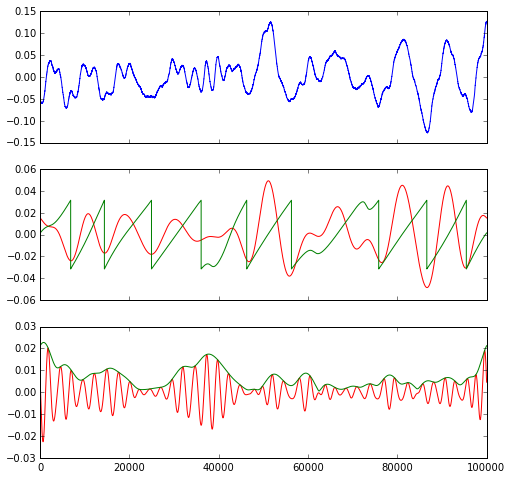

In [39]:
t0 = 1000
rec = x[0,-int((t0)/dt):]+y[0,-int((t0)/dt):]+x[1,-int((t0)/dt):]+y[1,-int((t0)/dt):]
L = filt(rec,1,4,18)
H = filt(rec,1,30,60)
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
f.set_size_inches(8,8)
mH = np.mean(H)
mL = np.mean(L)
mr = np.mean(rec)
ax1.plot(rec-mr)
amp = np.abs(hilbert(H-mH))
ang = np.angle(hilbert(L-mL))
ax2.plot(L,'r')

ax2.plot(.01*ang+mL,'g')
ax3.plot(H,'r')
ax3.plot(amp+mH,'g')


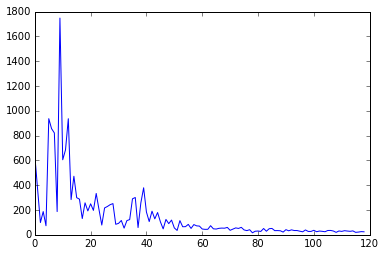

In [40]:
plt.plot(np.abs(fft(rec)[1:120]))

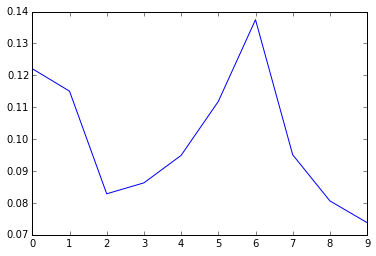

In [41]:
a = Cros(rec,1,4,18,30,60)
plt.plot(a)

0.00474138962309


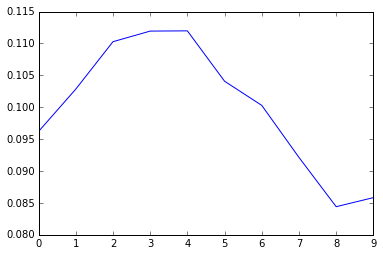

In [54]:
rec = sum(x) + sum(y)
a = all_cros(rec,dt,T,4,18,30,60)
plt.plot(a);
print Entropy(a)

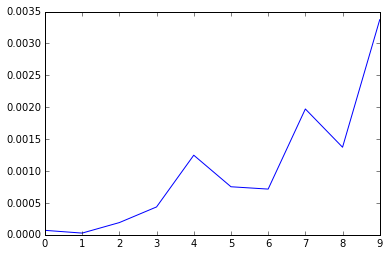

In [63]:
m = 10
cr = np.zeros(m)
for i in range(m):
    xx = np.array([[24., 24.],[28., 11.]])
    XX = np.array([[22., 17.],[14.5, 9.5]])
    xX = np.array([[i*2, 0.],[0., 0.]])
    alpha = .05
    dt = .01
    Ts = 50
    T = 1000*Ts
    noise = .0005
    x, y, he, hi = network(Ts = Ts, dt = dt,  noise = noise, alpha = alpha, xx = xx, XX = XX, xX = xX)
    rec = sum(x) + sum(y)
    a = all_cros(rec,dt,T,4,18,30,60)
    cr[i] = Entropy(a)
plt.plot(cr)